# Performs Pearson's correlation and colocalization analysis between marker pairs for all cells

In [1]:
import pickle
import pandas as pd
import os
import glob
import sys
import seaborn as sns
import numpy as np
from pathlib import Path 
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import combinations
from tqdm.notebook import tqdm, trange
from ast import literal_eval
import scipy

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from my_io import display_list_image, read_tiff_files
from colocalization import generate_pearson_metric_masked
from config import *

In [4]:
# Figures location   
save_path = f"{data_figure}/boxplots/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Loading the datasets

In [5]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [6]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_UC = pickle.load(open(pickle_name_temp, "rb"))

In [7]:
df_path = data_dir / "BM_UC_indices_all.csv"
df_indices = pd.read_csv(df_path)

In [8]:
df_BM = df_indices.loc[df_indices['CellType']=='BM']
df_BM = df_BM.fillna('')
cellList_BM = []
for index, row in df_BM.iterrows(): 
    templist = []
    if row.indices!='':
        templist.append(literal_eval(row.indices))
        cellList_BM.append(list(templist[0]))
    else:
        cellList_BM.append(templist)

In [9]:
df_UC = df_indices.loc[df_indices['CellType']=='UC']
df_UC = df_UC.fillna('')
cellList_UC = [] #empty list
for index, row in df_UC.iterrows(): 
    templist = []
    if row.indices!='':
        templist.append(literal_eval(row.indices))
        cellList_UC.append(list(templist[0]))
    else:
        cellList_UC.append(templist)

In [10]:
list_area_BM = []
list_area_UC = []

for cell in range(len(zoomed_image_list_BM)):       
    mask_temp = zoomed_mask_BM[cell].copy()/255
    area_temp = mask_temp.sum()
    list_area_BM.append(area_temp)

for cell in range(len(zoomed_image_list_UC)):       
    mask_temp = zoomed_mask_UC[cell].copy()/255
    area_temp = mask_temp.sum()
    list_area_UC.append(area_temp)

### Pearson's correlation

In [11]:
def minMaxScaleThreshold(img, thresh):
    img = np.true_divide(img - np.min(img), \
                        np.zeros_like(img) + np.max(img) - np.min(img))
    img[img < thresh] = 0
    
    return img

In [12]:
BM_pairDict = {}
for cell in trange(len(cellList_BM)):
    for entry in combinations(cellList_BM[cell], 2):
        image1_temp = zoomed_image_list_BM[cell][entry[0]].copy()
        image2_temp = zoomed_image_list_BM[cell][entry[1]].copy()     
        
        image1_temp = minMaxScaleThreshold(image1_temp, 0.3)
        image2_temp = minMaxScaleThreshold(image2_temp, 0.3)
        
        metrics_temp = generate_pearson_metric_masked(image1_temp, image2_temp)
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in BM_pairDict.keys():
            BM_pairDict[dictKey] = []
        BM_pairDict[dictKey].append(metrics_temp) 

  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
UC_pairDict = {}
for cell in trange(len(cellList_UC)):
    for entry in combinations(cellList_UC[cell], 2):
        image1_temp = zoomed_image_list_UC[cell][entry[0]].copy()
        image2_temp = zoomed_image_list_UC[cell][entry[1]].copy()
        
        image1_temp = minMaxScaleThreshold(image1_temp, 0.3)
        image2_temp = minMaxScaleThreshold(image2_temp, 0.3)
        
        metrics_temp = generate_pearson_metric_masked(image1_temp, image2_temp)
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in UC_pairDict.keys():
            UC_pairDict[dictKey] = []
        UC_pairDict[dictKey].append(metrics_temp) 

  0%|          | 0/35 [00:00<?, ?it/s]

In [14]:
BM_pair_df = pd.DataFrame.from_dict(BM_pairDict.items())
BM_pair_df.columns = ['Marker', 'Pearson']
BM_pair_df = BM_pair_df.explode('Pearson')
BM_pair_df['Cell Type'] = 'BM'

In [15]:
UC_pair_df = pd.DataFrame.from_dict(UC_pairDict.items())
UC_pair_df.columns = ['Marker', 'Pearson']
UC_pair_df = UC_pair_df.explode('Pearson')
UC_pair_df['Cell Type'] = 'UC'

In [16]:
frames = [BM_pair_df, UC_pair_df]
result = pd.concat(frames)
result = result.sort_values(by=['Marker'])

In [17]:
result

,Marker,Pearson,Cell Type
0,ATF6_BetaTubulin,0.14668,BM
45,ATF6_BetaTubulin,0.060261,UC
45,ATF6_BetaTubulin,0.086596,UC
45,ATF6_BetaTubulin,0.015324,UC
45,ATF6_BetaTubulin,0.375586,UC
...,...,...,...
54,TOM20_WGA,0.378365,BM
54,TOM20_WGA,0.023219,BM
54,TOM20_WGA,0.044521,BM
54,TOM20_WGA,0.498214,BM


  0%|          | 0/55 [00:00<?, ?it/s]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ATF6_WGA_BM v.s. ATF6_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.027e-01 U_stat=9.000e+00
BetaTubulin_ConcanavalinA_BM v.s. BetaTubulin_ConcanavalinA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.113e-01 U_stat=1.700e+01
BetaTubulin_DAPI_BM v.s. BetaTubulin_DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.809e-01 U_stat=9.100e+01
BetaTubulin_GOLPH4_BM v.s. BetaTubulin_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.561e-04 U_stat=1.460e+02
BetaTubulin_HSP60_BM v.s. BetaTubulin_HSP60_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.427e-04 U_stat=8.200e+01
BetaTubulin_Nucleolin_BM v.s. BetaTubulin_Nucleolin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.800e-01 U_stat=8.500e+01
BetaTubulin_Phalloidin_BM v.s. BetaTubulin_Phalloidin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=4.945e-02 U_st

<ipython-input-18-b5c5dd86a1ef>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


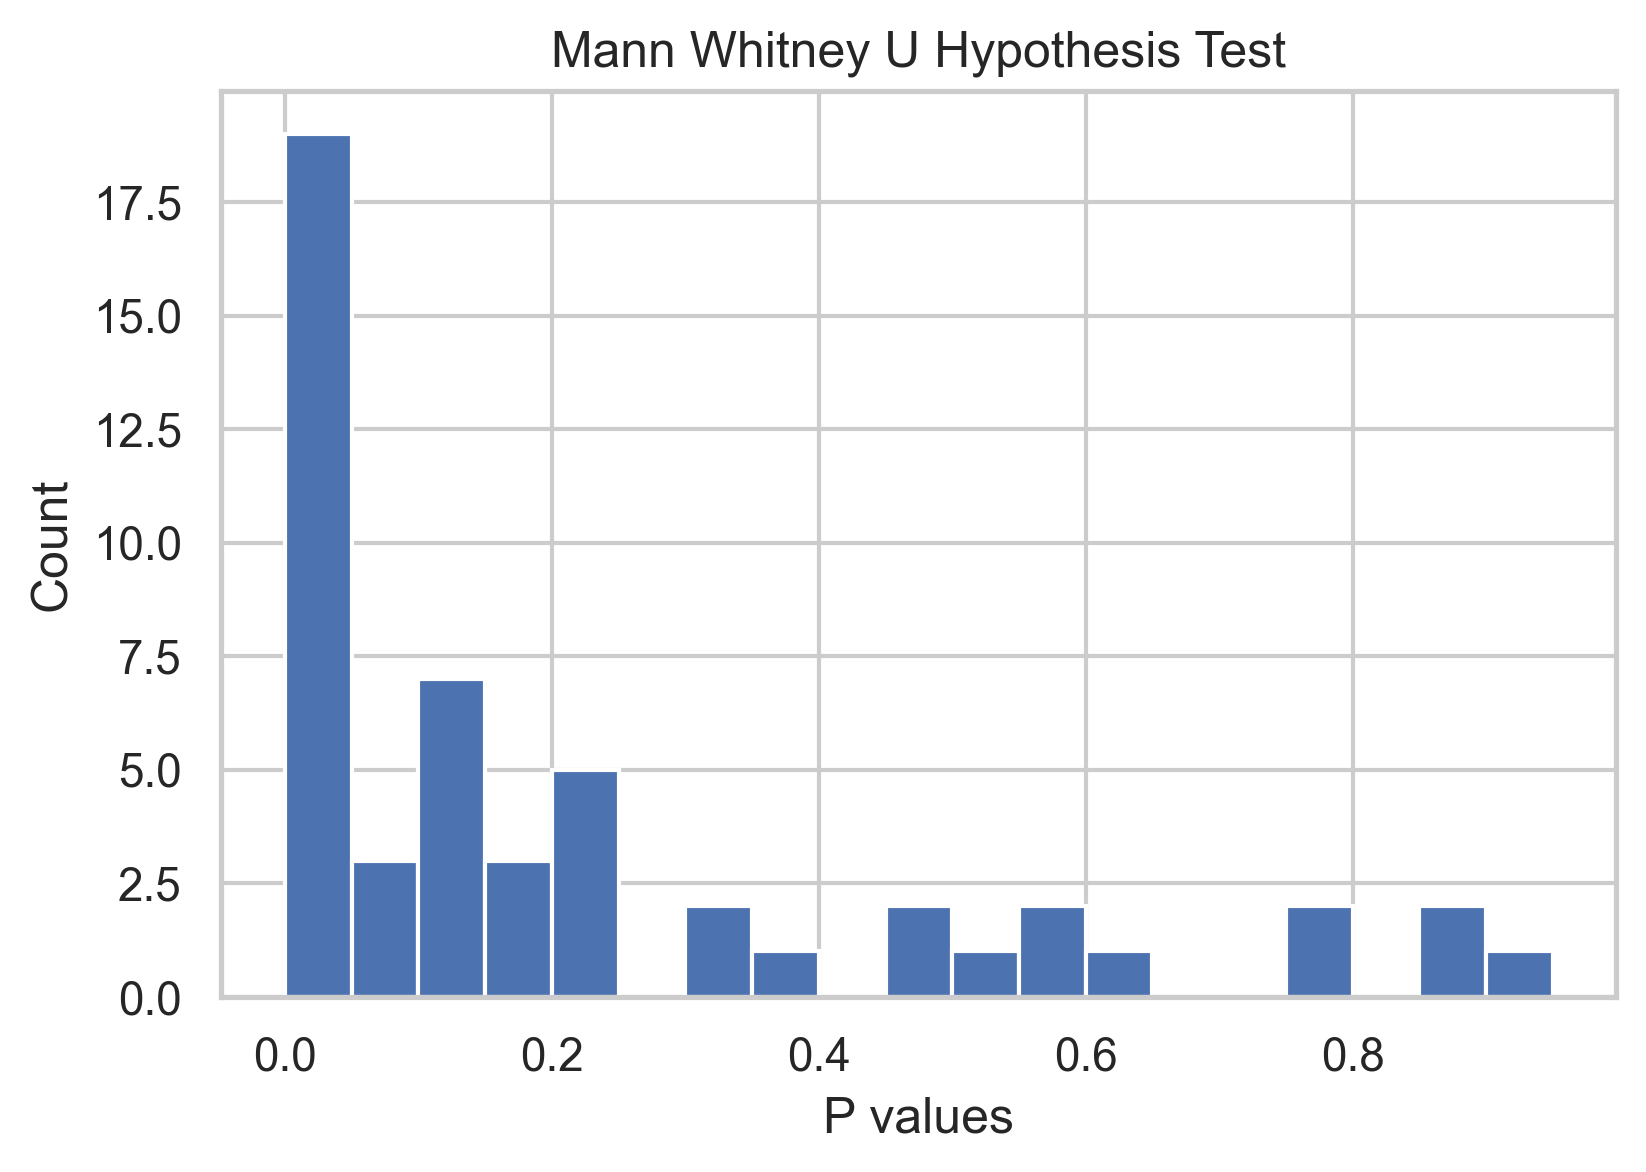

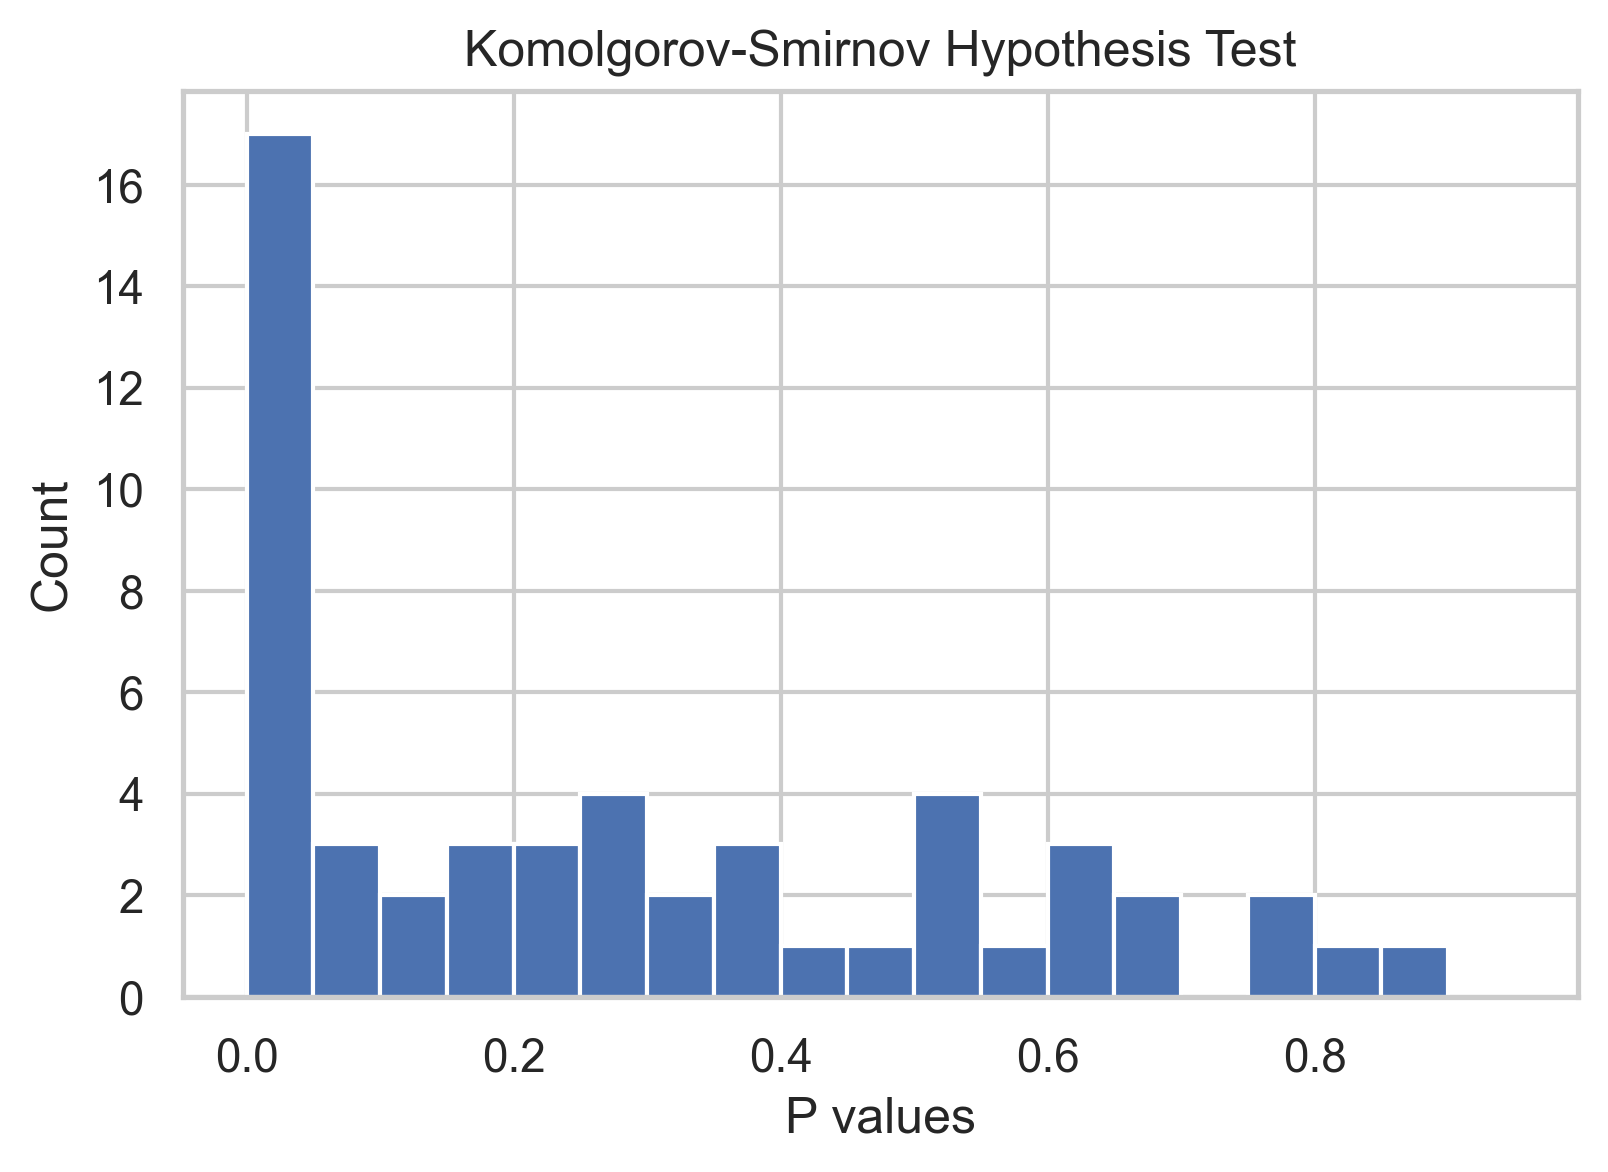

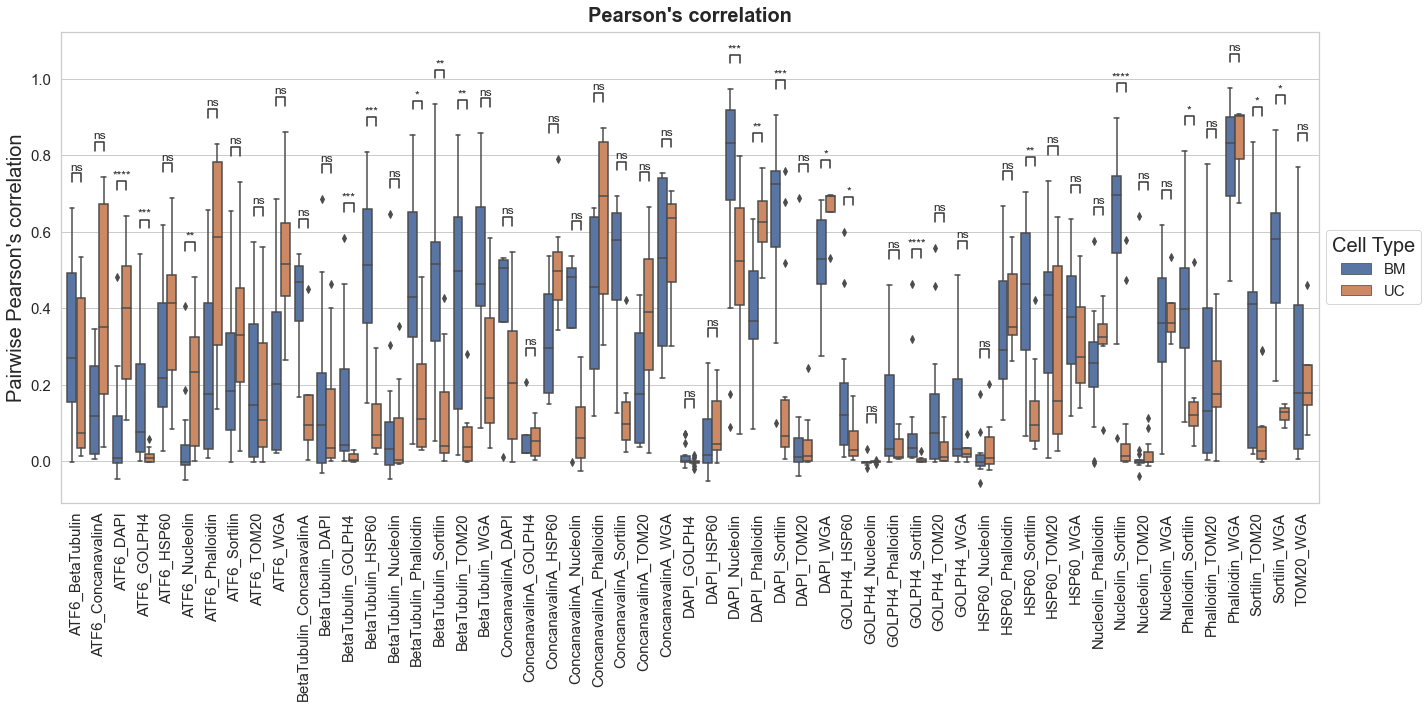

In [18]:
sns.set_theme(style="whitegrid")

data = result

data['Pearson'] = data['Pearson'].values.astype(float)

x = "Marker"
y = "Pearson"
hue = "Cell Type"
hue_order=['BM', 'UC']
channel_pairs = data["Marker"].unique()

# stat test BM vs UC within each marker
pVals = pd.DataFrame(columns = ['MannWhitney', 'KS'])
for ii, markerName in enumerate(tqdm(channel_pairs)):
    
    bm = data.loc[(data['Marker'] == markerName) & (data['Cell Type'] == 'BM')]['Pearson'].values.astype(float)
    uc = data.loc[(data['Marker'] == markerName) & (data['Cell Type'] == 'UC')]['Pearson'].values.astype(float)
    
    res1 = scipy.stats.mannwhitneyu(bm, uc, alternative = 'two-sided')
    res2 = scipy.stats.ks_2samp(bm, uc, alternative = 'two-sided')
    
    pVals = pVals.append(pd.DataFrame(np.array([res1.pvalue, res2.pvalue]).reshape(1, -1), columns = ['MannWhitney', 'KS']))
    
pVals = pVals.reset_index(drop = True)
    
# plot histogram of p values
fig, ax = plt.subplots(dpi = 300)
ax.set_xlabel('P values')
ax.set_ylabel('Count')
ax.set_title('Mann Whitney U Hypothesis Test')
ax.hist(pVals['MannWhitney'], bins = np.arange(0, 1, 0.05))

fig, ax = plt.subplots(dpi = 300)
ax.set_xlabel('P values')
ax.set_ylabel('Count')
ax.set_title('Komolgorov-Smirnov Hypothesis Test')
ax.hist(pVals['KS'], bins = np.arange(0, 1, 0.05))

# plot boxplot of pearson's correlation with statistical significance
plt.figure(figsize=(20, 10))
plt.title('Pearson\'s correlation between markers')

box_pairs=[((chan, "BM"), (chan, "UC")) for chan in channel_pairs]

g = sns.boxplot(data=data, hue=hue, x=x, y=y) 
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

add_stat_annotation(g, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction =None)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_title(f"Pearson's correlation",fontsize= 20, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("Pairwise Pearson's correlation",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
image_path_png = save_path+"/pearson_BM_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

### Colocalization

In [19]:
BM_colocDict = {}
for cell in trange(len(cellList_BM)):
    for entry in combinations(cellList_BM[cell], 2):
        image1_temp = zoomed_image_list_BM[cell][entry[0]].copy()
        image1_temp = (image1_temp >= np.quantile(image1_temp, 0.9)).astype(np.int8)        
        image2_temp = zoomed_image_list_BM[cell][entry[1]].copy()
        image2_temp = (image2_temp >= np.quantile(image2_temp, 0.9)).astype(np.int8)
        image_temp_all = (image2_temp * image1_temp)/list_area_BM[cell]
        metrics_temp = image_temp_all.sum()
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in BM_colocDict.keys():
            BM_colocDict[dictKey] = []
        BM_colocDict[dictKey].append(metrics_temp) 

  0%|          | 0/32 [00:00<?, ?it/s]

In [20]:
UC_colocDict = {}
for cell in trange(len(cellList_UC)):
    for entry in combinations(cellList_UC[cell], 2):
        image1_temp = zoomed_image_list_UC[cell][entry[0]].copy()
        image1_temp = (image1_temp >= np.quantile(image1_temp, 0.9)).astype(np.int8)        
        image2_temp = zoomed_image_list_UC[cell][entry[1]].copy()
        image2_temp = (image2_temp >= np.quantile(image2_temp, 0.9)).astype(np.int8)
        image_temp_all = (image2_temp * image1_temp)/list_area_UC[cell]
        metrics_temp = image_temp_all.sum()
        dictKey = channel_names[entry[0]] + '_' + channel_names[entry[1]]
        if not dictKey in UC_colocDict.keys():
            UC_colocDict[dictKey] = []
        UC_colocDict[dictKey].append(metrics_temp) 

  0%|          | 0/35 [00:00<?, ?it/s]

In [21]:
BM_coloc_df = pd.DataFrame.from_dict(BM_colocDict.items())
BM_coloc_df.columns = ['Marker', 'Coloc']
BM_coloc_df = BM_coloc_df.explode('Coloc')
BM_coloc_df['Cell Type'] = 'BM'

In [22]:
UC_coloc_df = pd.DataFrame.from_dict(UC_colocDict.items())
UC_coloc_df.columns = ['Marker', 'Coloc']
UC_coloc_df = UC_coloc_df.explode('Coloc')
UC_coloc_df['Cell Type'] = 'UC'

In [23]:
frames = [BM_coloc_df, UC_coloc_df]
coloc_df = pd.concat(frames)
coloc_df = coloc_df.sort_values(by=['Marker'])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ATF6_WGA_BM v.s. ATF6_WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.798e-02 U_stat=8.000e+00
BetaTubulin_ConcanavalinA_BM v.s. BetaTubulin_ConcanavalinA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.779e-01 U_stat=1.600e+01
BetaTubulin_DAPI_BM v.s. BetaTubulin_DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.490e-01 U_stat=1.030e+02
BetaTubulin_GOLPH4_BM v.s. BetaTubulin_GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=4.245e-02 U_stat=1.190e+02
BetaTubulin_HSP60_BM v.s. BetaTubulin_HSP60_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.601e-02 U_stat=7.100e+01
BetaTubulin_Nucleolin_BM v.s. BetaTubulin_Nucleolin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.257e-01 U_stat=1.160e+02
BetaTubulin_Phalloidin_BM v.s. BetaTubulin_Phalloidin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=2.648e-01 U_st

<ipython-input-24-045b4f76a221>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


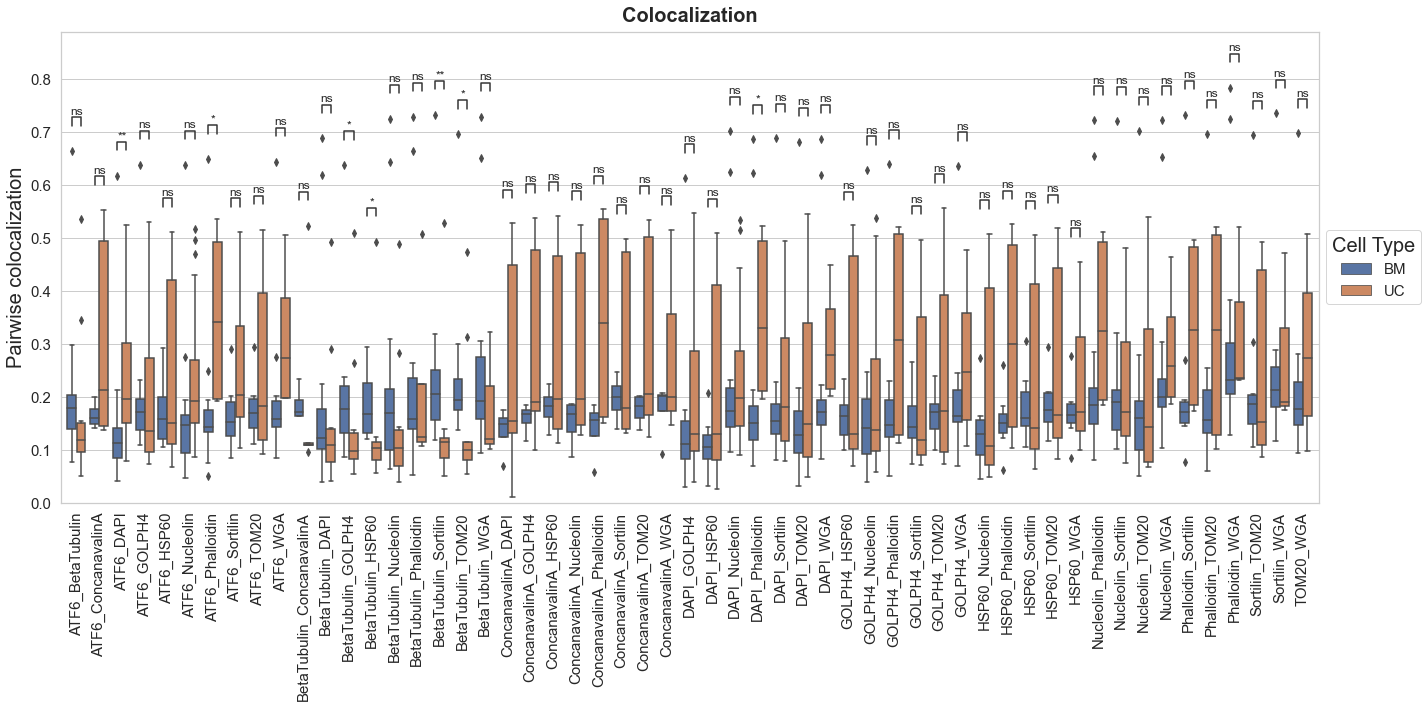

In [24]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
plt.title('Colocalization between markers')

data = coloc_df

data['Coloc'] = data['Coloc'].values.astype(float)

x = "Marker"
y = "Coloc"
hue = "Cell Type"
hue_order=['BM', 'UC']
channel_pairs = data["Marker"].unique()
box_pairs=[((chan, "BM"), (chan, "UC")) for chan in channel_pairs]
g = sns.boxplot(data=data, hue=hue, x=x, y=y)
g.set_ylim(0, 0.8)
add_stat_annotation(g, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction=None)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_title(f"Colocalization",fontsize= 20, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("Pairwise colocalization",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
image_path_png = save_path+"/colocalization_BM_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()